In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Deafening
z2_raw = loadmat('data_from_Fabiola/zscore_deafening.mat')
z_predeaf, z_postdeaf = z2_raw['zscore_pre'][:,0], z2_raw['zscore_post'][:,0]

In [3]:
# White Noise Perturbation
# z1_raw = loadmat('data_from_Fabiola/zscore_song.mat')
# z_correct, z_pert = z1_raw['zscore_song'], z1_raw['zscore_songwn'] # less data
z_correct = loadmat('data_from_Fabiola/mean_mat.mat')['mean_mat']
z_pert = loadmat('data_from_Fabiola/mean_mat2.mat')['mean_mat2']
z_correct = (z_correct - z_correct[:,54:60].mean(axis=1)[:,None])[:,62:84].mean(axis=1)
z_pert = (z_pert - z_pert[:,54:60].mean(axis=1)[:,None])[:,62:84].mean(axis=1)

In [4]:
m, s = z_correct.mean(), z_correct.std()
z_correct = (z_correct - m) / s
z_pert = (z_pert - m) / s

In [5]:
m, s = z_predeaf.mean(), z_predeaf.std()
z_predeaf = (z_predeaf - m) / s
z_postdeaf = (z_postdeaf - m) / s

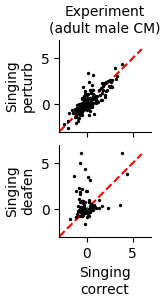

In [6]:
fig, ax = plt.subplots(2, figsize=(3, 3), sharex='all')
ax[0].scatter(z_correct, z_pert, s=8, c='k', zorder=-1)
ax[1].scatter(z_predeaf, z_postdeaf, s=8, c='k', zorder=-1)
for i, l in enumerate(['Singing\nperturb', 'Singing\ndeafen']):
    ax[i].plot([-3,6], [-3,6], c='r', ls='--', zorder=-2)
    ax[i].set(xlim=[-3,7], ylim=[-3,7], xticks=[0,5], yticks=[0,5], 
              ylabel=l)
    ax[i].set_rasterization_zorder(0)
    ax[i].axes.set_aspect('equal')
ax[0].set_title('Experiment\n(adult male CM)')
ax[-1].set(xlabel='Singing\ncorrect')
fig.savefig('svg/joint_dist_c_vs_nc_experiment.svg', bbox_inches='tight', dpi=300)

(39,) (29,)
0.056933571136357955


[Text(0.5, 0, '| residual |'), Text(0, 0.5, 'density'), (0.0, 2.625)]

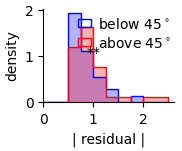

In [7]:
from scipy.stats import ranksums
fig, ax = plt.subplots(1, figsize=(1.8, 1.5), sharex='all', sharey='all')
diff = z_pert - z_correct
m, std = diff.mean()*0, diff.std()
dists = [diff[diff>m+std], -diff[diff<m-std]]
print(dists[0].shape, dists[1].shape)
pval = ranksums(*dists, alternative='greater').pvalue
print(pval)
ax.hist(dists, bins=10, range=(0, 2.5), density=True, color=['r', 'b'],
        alpha=0.3, histtype='stepfilled')
ax.hist(dists, bins=10, range=(0, 2.5), density=True, color=['r', 'b'], histtype='step', 
        label=['above 45$^\\circ$', 'below 45$^\\circ$'])
ax.legend(loc=(0.22,0.5))
ax.text(1, 1, '**', ha='center')
ax.set(xlabel='| residual |', ylabel='density', xlim=[0,ax.get_xlim()[1]])
# fig.savefig('svg/pert_diff_experiment.svg')

(283,)
5.353926346387085e-10


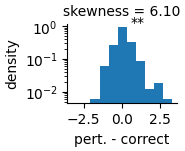

In [8]:
from scipy.stats import wilcoxon, skewtest
fig, ax = plt.subplots(1, figsize=(1.8, 1.5), sharex='all', sharey='all')
diff = z_pert - z_correct
print(diff.shape)
# pval = wilcoxon(diff, alternative='greater').pvalue
test = skewtest(diff, alternative='greater')
print(test.pvalue)
m = max(-diff.max(), diff.max())
ax.hist(diff, bins=11, range=(-m, m), density=True)
ax.text(1, 1, '**', ha='center')
ax.set(xlabel='pert. - correct', ylabel='density', yscale='log', 
       title='skewness = %.2f' % test.statistic)
fig.savefig('svg/pert_diff_experiment.svg')

(88,)
1.413155639862499e-06


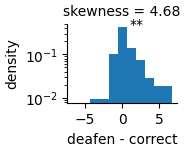

In [9]:
from scipy.stats import wilcoxon, skewtest
fig, ax = plt.subplots(1, figsize=(1.8, 1.5), sharex='all', sharey='all')
diff = z_postdeaf - z_predeaf
print(diff.shape)
test = skewtest(diff, alternative='greater')
print(test.pvalue)
m = max(-diff.max(), diff.max())
ax.hist(diff, bins=11, range=(-m, m), density=True)
ax.text(2, 0.4, '**', ha='center')
ax.set(xlabel='deafen - correct', ylabel='density', yscale='log', 
       title='skewness = %.2f' % test.statistic)
fig.savefig('svg/deaf_diff_experiment.svg')